# W&B 란?
- Weights & Biases(W&B)는 모델 학습, 파인 튜닝을 위한 AI 개발자 플랫폼
- 기록 시스템을 통해 모델과 데이터가 추적되고 버전 관리되며, 머신러닝 파이프라인을 빠르게 반복 가능
- 모델 훈련, 실험 추적, 시각화, 하이퍼파라미터 튜닝, 모델 버전 관리 등을 지원하여 개발자가 더 나은 모델을 빠르게 개발할 수 있음

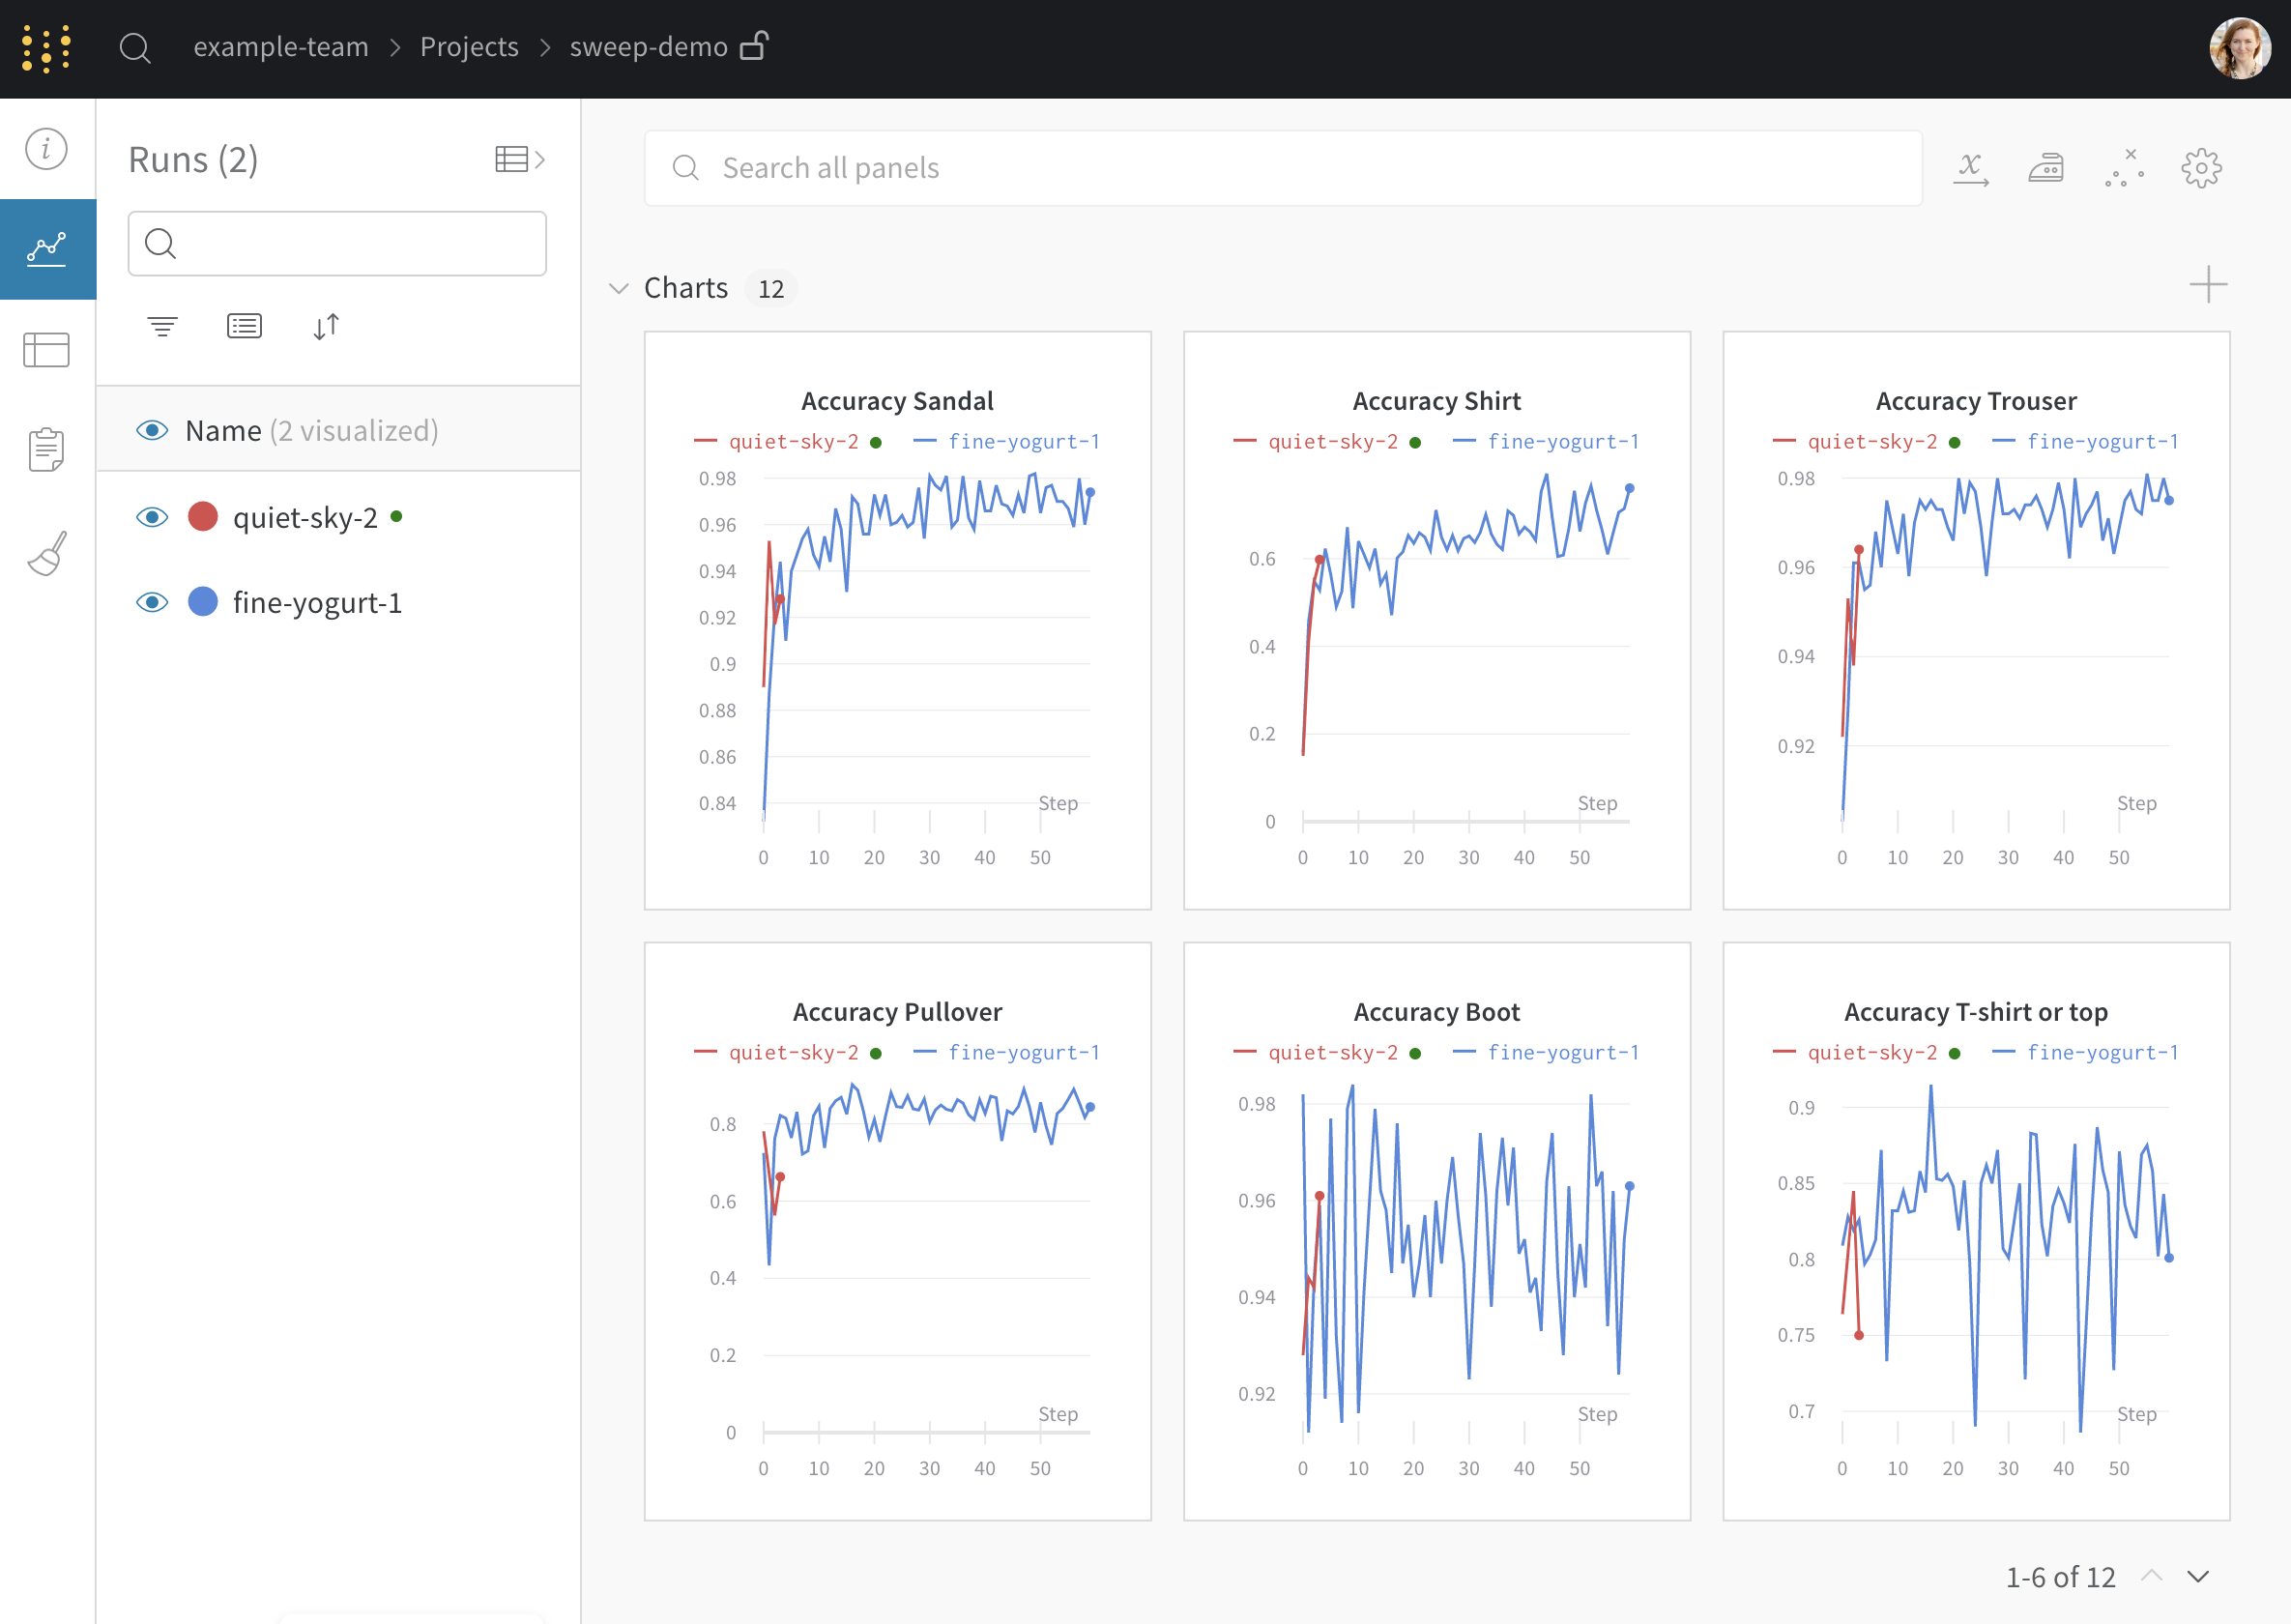

## W&B의 주요 기능
- 실험 추적 (Experiment Tracking)
    - 모델 훈련 과정에서 손실, 정확도 등 주요 지표를 추적하고 시각화
    - 하이퍼파라미터와 메트릭을 기록
    - 실험 기록을 대시보드에서 확인하고 팀과 공유 가능
- 모델 관리 (Model Management)
    - 모델 체크포인트를 저장하고 버전 관리
    - 파일과 모델을 기록해 재현성을 보장
- 데이터셋 버전 관리 (Dataset Versioning)
    - 데이터셋을 관리하고 변경 사항을 추적
- 하이퍼파라미터 튜닝 (Hyperparameter Optimization)
    - 자동화된 스윕(Sweep) 기능을 통해 다양한 하이퍼파라미터 조합을 테스트하고 최적의 조합을 찾음
- 시각화 (Visualization)
    - 실험 메트릭, 모델 성능 등 시각화 지원
    - 대시보드에서 커스텀 차트를 만들어 모델 성능을 비교
- 협업 및 공유 (Collaboration & Sharing):
    - 팀 프로젝트에서 실험 기록을 공유하고 협업 가능
    - 프로젝트, 실험 기록, 대시보드를 링크로 공유 가능

## W&B를 사용하는 이유
- 모델 훈련 및 실험 관리 자동화
- 실험 기록 및 버전 관리
- 하이퍼파라미터 튜닝 및 최적화
- 데이터셋 및 모델 관리
- 협업과 공유 기능 강화

In [1]:
import pandas as pd
import numpy as np
import random
import os
import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

DATA_PATH = "../data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)

# Min-Max Scaling
scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft = scaler.transform(train_ft)

# 정답 데이터
target = train["survived"].to_numpy().reshape(-1,1) # 정답 데이터 2차원으로 변경

class TitanicDataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        item = {}
        item["x"] = torch.Tensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item

In [2]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

class Net(torch.nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(n_features, 12),
            torch.nn.BatchNorm1d(12),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(12, 8),
            torch.nn.BatchNorm1d(8),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(8, 4),
            torch.nn.BatchNorm1d(4),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(4, 1)
        )
    def forward(self, x):
        return self.seq(x)

def train_loop(dl, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train()
    for batch in dl:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dl)
    return epoch_loss

@torch.no_grad()
def test_loop(dl, model, loss_fn, device):
    epoch_loss = 0
    model.eval()

    act = torch.nn.Sigmoid()
    pred_list = []
    for batch in dl:
        pred = model( batch["x"].to(device) )
        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device) )
            epoch_loss += loss.item()

        pred = act(pred)
        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    pred = np.concatenate(pred_list)
    epoch_loss /= len(dl)
    return epoch_loss, pred

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

loss_fn = torch.nn.BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
n_features = train_ft.shape[1]


x_train, x_valid, y_train, y_valid = train_test_split(train_ft,target,shuffle=True, random_state=SEED)


train_dt = TitanicDataset(x_train, y_train)
train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

valid_dt = TitanicDataset(x_valid, y_valid)
valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

# Quickstart
1. https://wandb.ai/site 에서 가입후 로그인
2. 설치하기
```bash
!pip install wandb
```
3. W&B에 로그인
```python
import wandb
wandb.login()
```
4. 메시지가 나타나면 api 키 입력
- 다음의 url 에서 api 키 복사
    - https://wandb.ai/authorize

In [3]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: koeyhi (koeyhi-student). Use `wandb login --relogin` to force relogin


True

# wandb.init 함수
- W&B에 추적 및 로그를 기록할 run 시작
- 프로젝트를 초기화하고 설정
- 주요 파라미터
    - project: run이 기록될 프로젝트 이름 설정
        - 해당 프로젝트명이 없을 경우 지정한 이름의 프로젝트가 생성됨
    - name: run 이름(생략 시 자동 생성)
    - config: 실험에서 전역적으로 기록해야 하는 모델의 하이퍼파라미터, 피처 개수 등을 딕셔너리 형태로 전달

In [22]:
run = wandb.init(
    project="my-project",
    config={
        "optimizer": "adam",
        "batch_size": batch_size,
        "lr": 0.001,
        "Validation": "holdout",
        "n_features": n_features
    }
)

In [10]:
run.config

{'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'Validation': 'holdout', 'n_features': 10}

In [9]:
wandb.config

{'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'Validation': 'holdout', 'n_features': 10}

In [23]:
run.name

'crimson-resonance-2'

# wandb.log 함수 또는 run.log 메서드
- 학습 중에 발생하는 손실, 다양한 평가지표를 기록
- log를 이용해 기록된 데이터는 대시보드에 시각화
- 딕셔너리 형태로 전달

In [24]:
reset_seeds(SEED)
model = Net(n_features).to(device)
optimizer = torch.optim.Adam(model.parameters())

for i in range(20):
    train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
    valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)

    score = roc_auc_score(y_valid, pred)
    print(train_loss, valid_loss, score)
    run.log({
        "auc": score,
        "train-loss": train_loss,
        "valid-loss": valid_loss,
    })

0.6647676121104847 0.684358187019825 0.6090022566086395
0.6048410589044745 0.5913052260875702 0.8598081882656351
0.5621497983282263 0.5444023311138153 0.8698823339780786
0.5246359584006396 0.5208272337913513 0.8595664087685364
0.5021447119387713 0.5063250511884689 0.8615006447453256
0.48276105387644336 0.4883158504962921 0.8681092843326885
0.4645242609760978 0.4798857681453228 0.8754432624113474
0.4586799009279771 0.46735598519444466 0.8778610573823339
0.45451476086269726 0.46347200125455856 0.8775386847195358
0.43477688052437524 0.46185943111777306 0.8733478401031592
0.436325957829302 0.4516912251710892 0.8759268214055448
0.423205088485371 0.44176656007766724 0.8741537717601547
0.4105742438272996 0.43561533093452454 0.8780222437137332
0.406760264526714 0.4331303499639034 0.881084784010316
0.403691057454456 0.4227566607296467 0.8840667311411992
0.40165632285855035 0.4227089136838913 0.8879352030947775
0.3985580856149847 0.4193439707159996 0.8862427466150872
0.38702069222927094 0.410383

In [25]:
run.summary["auc"] = 0.99

- run 종료

In [26]:
run.finish() # wandb.finish()

auc,▁▇▇▇▇▇▇██▇▇▇████████
train-loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
valid-loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
auc,0.99
train-loss,0.38508
valid-loss,0.39967
